The goal of this notebook is to catagorize pitchers using k-means clustering (from scratch and with Scikit-learn) to see how the winners of the 2022 cy young winners compare to the groups they are assigned to. 

In [351]:
# Importing libraries 
import numpy as np
import pandas as pd 
from pybaseball import pitching_stats
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
from IPython.display import clear_output

## 2022 CY Young Winners were Sandy Alcantara and Justin Verlander.



In [352]:
# Importing and cleaning data 
players = pitching_stats(2022)
players.sort_index(inplace=True)
JF = players.iloc[0]
SA = players.iloc[4]

print(JF)
print(SA)




IDfg                     8700
Season                   2022
Name         Justin Verlander
Team                      HOU
Age                        39
                   ...       
Location+                 107
Pitching+                 109
Stf+ FO                   NaN
Loc+ FO                   NaN
Pit+ FO                   NaN
Name: 0, Length: 393, dtype: object
IDfg                   18684
Season                  2022
Name         Sandy Alcantara
Team                     MIA
Age                       26
                  ...       
Location+                105
Pitching+                107
Stf+ FO                  NaN
Loc+ FO                  NaN
Pit+ FO                  NaN
Name: 4, Length: 393, dtype: object


In [353]:
features = ["ERA", 'WHIP', 'H', 'R', "HR", 'BB', 'HBP']
data = players[features].copy()

1. Scale the data
2. Initalize random centroids
3. Label each data point based on how far that data point is from each centroid (cluster assignment for each pitcher)
4. Update centroids
5. Repeat steps 3, 4 until centroids stop changing

In [354]:
data = ((data - data.min()) / (data.max() - data.min())) * 9 + 1
data.head

<bound method NDFrame.head of           ERA       WHIP          H          R     HR         BB        HBP
0    1.000000   1.000000   1.000000   1.000000   2.44   2.263158   3.647059
1    2.060345   2.983051   2.192771   2.090909   6.40   4.157895   3.117647
2    2.163793   5.271186   2.084337   2.636364   3.88  10.000000   2.058824
3    2.267241   3.440678   4.036145   2.636364   3.88   5.736842   8.411765
4    2.370690   3.288136   7.289157   4.272727   3.88   5.578947   5.235294
5    2.500000   3.745763   1.867470   1.272727   3.16   4.631579   1.529412
6    2.887931   3.745763   5.337349   2.636364   2.44   2.736842   2.588235
7    3.043103   2.525424   1.000000   2.227273   4.96   3.684211   2.058824
8    3.043103   2.220339   1.542169   2.772727   3.52   5.105263   6.823529
9    3.120690   3.593220   4.144578   2.909091   3.16   3.052632   5.235294
10   3.767241   6.033898   6.421687   4.818182   2.08   8.263158   6.294118
11   3.922414   4.203390   7.072289   4.681818   4.60   3.

In [355]:
data.describe()


,ERA,WHIP,H,R,HR,BB,HBP
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,5.112069,5.589831,5.843373,5.112121,5.432000,5.129825,4.458824
std,2.149708,2.284856,2.398613,2.070907,2.271429,1.964031,2.164063
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.922414,3.745763,4.469880,4.000000,3.880000,3.684211,3.117647
50%,4.879310,5.728814,6.096386,4.954545,5.320000,5.263158,4.176471
75%,6.586207,6.796610,7.397590,6.181818,7.120000,6.052632,5.764706
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [356]:

# Iterate through each column in our data, then calls x.sample to select a single random value from that column and turns it into a float. 
# Next it appends these centroids into a list and when the loop is complete it it creates a dataframe out of them with each column being each centroid. 
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis = 1)





In [357]:
centroids = random_centroids(data, 4)
centroids

/var/folders/zh/rgqvb6zn45j1dm3h1gw654r00000gn/T/ipykernel_7704/839499929.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  centroid = data.apply(lambda x: float(x.sample()))


,0,1,2,3
ERA,7.155172,5.189655,8.189655,4.879310
WHIP,7.254237,5.576271,4.203390,9.542373
H,5.120482,9.349398,4.036145,4.036145
R,3.454545,1.000000,1.272727,4.272727
HR,3.880000,5.680000,1.000000,7.480000
BB,2.263158,4.631579,1.000000,3.368421
HBP,2.058824,2.588235,5.235294,4.705882


In [358]:
# Label each datapoint according to the cluster centers. 
# Looks at each player (data point) and finds the eculidian distance between the player and each centroid. 
# Next it finds the cluster center that is closest to that player. 

def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) **2).sum(axis=1)))
    return distances.idxmin(axis=1)



In [359]:
labels = get_labels(data, centroids)
labels.value_counts()

3    21
0    12
1     8
2     4
Name: count, dtype: int64

In [360]:
# Grouping data by labels. 
# Finding the geometric mean of each cluster.
def new_centroids(data, labels, k):
    return data.groupby(labels).apply(lambda x: np.exp(np.log(x)).mean()).T

In [361]:
def plot_clusters(data, labels, centroids, iterations): 
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration{iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels, marker= "*")
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

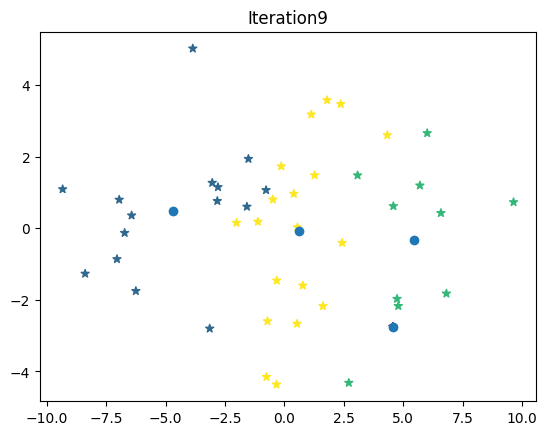

In [362]:
max_iterations = 100
centroid_count = 3
k = 5

centroids = random_centroids(data, k)
old_centroids = pd.DataFrame()
iteration = 1 

while iteration < max_iterations and not centroids.equals(old_centroids): 
    old_centroids = centroids 

    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, k)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

In [363]:
centroids

,0,1,2,3
ERA,2.163793,7.560345,2.975862,4.458711
WHIP,5.271186,7.691525,3.349153,5.126673
H,2.084337,7.578313,2.821687,6.261890
R,2.636364,7.272727,2.554545,4.882775
HR,3.880000,7.576000,3.664000,4.751579
BB,10.000000,5.473684,4.126316,5.130194
HBP,2.058824,4.811765,3.223529,4.956656


In [364]:
labels 

0     2
1     2
2     0
3     3
4     3
5     2
6     2
7     2
8     2
9     2
10    3
11    3
12    2
13    3
14    3
15    2
16    3
17    3
18    2
19    3
20    3
21    3
22    3
23    3
24    3
25    3
26    3
27    3
28    3
29    1
30    1
31    1
32    3
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
dtype: int64

My groups seem to jump around a lot everytime I run the algorithm. A few of things could be happening: My code not be working they way I think  it is, the Cy Young is not based on objective data, or k-means is not a good usecase for this question. 